In [42]:
# simulate the hypergeometric distribution
# i.e. assume there are 1000 balls in a bag, 10 of which are red
# draw 50 balls from the bag, what is the probability of getting 10 red balls?
# repeat the experiment 1000 times and plot the histogram

import numpy as np
import matplotlib.pyplot as plt
N = 2000
n = 10
k = 4
def sample_balls(N, n, k, iterations = 10000):
    # N: total number of balls
    # n: number of balls drawn
    # k: number of red balls
    results = np.zeros(iterations)
    for _ in range(iterations):
        balls = np.zeros(N)
        balls[:k] = 1
        np.random.shuffle(balls)
        results[_] = np.sum(balls[:n])
    return results

res = sample_balls(N, n, k)


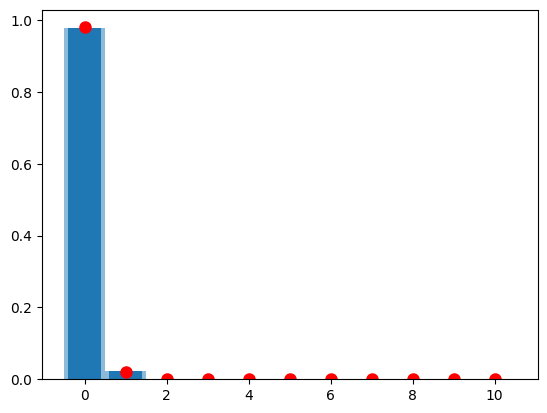

In [44]:
# now compare it to the pdf of the hypergeometric distribution
from scipy.stats import hypergeom

rv = hypergeom(N, k, n)
x = np.arange(0, n+1)
pmf = rv.pmf(x)
plt.hist(res, bins=np.arange(0, n+2)-0.5, density=True, alpha=0.5)
# plot the simulated data
unique, counts = np.unique(res, return_counts=True)
plt.bar(unique, counts/ sum(counts))

# compare it to a binomial that doesn't account for sampling with replacement
from scipy.stats import binom
rv = binom(n, k/N)
x = np.arange(0, n+1)
pmf = rv.pmf(x)
plt.plot(x, pmf, 'ro', ms=8)

In [45]:
# try a bayesian approach with cmdstanpy
import cmdstanpy
file = "hypergeometric.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)

In [46]:
data = {"pop" : N, "n_sampled" : n, "n_pos" : k}
fit = model.sample(data=data, iter_sampling=5000, iter_warmup=500, chains=2)

11:47:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

11:47:52 - cmdstanpy - INFO - CmdStan done processing.


In [47]:
# extract pd from the fit
samples = fit.draws_pd()

In [48]:
ans = samples["i"]

<BarContainer object of 1311 artists>

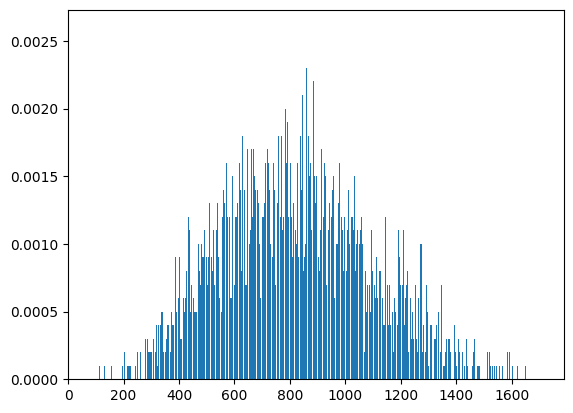

In [49]:
# make a bar plot of all the values in ans
unique, counts = np.unique(ans, return_counts=True)
plt.bar(unique, counts/ sum(counts))

<BarContainer object of 1311 artists>

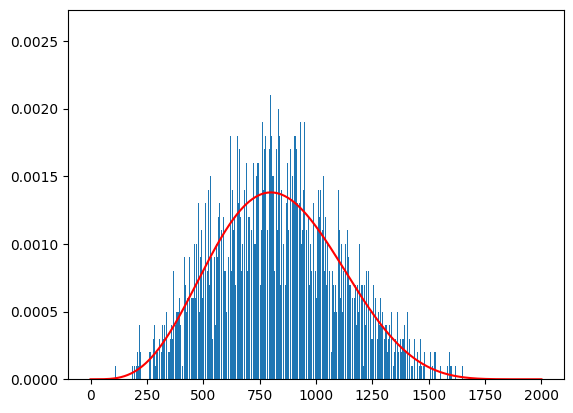

In [50]:
# compare this to the binomial distribution
# we'll do this by calculating the likelihood of the data over a range of values of p
p_range = np.linspace(0, 1, N)
likelihood = np.zeros_like(p_range)
for i, p in enumerate(p_range):
    likelihood[i] = np.prod(binom.pmf(k, n, p))

# normalize
likelihood = likelihood / np.sum(likelihood)

plt.plot(p_range*N, likelihood, 'r-')
plt.bar(unique, counts/ sum(counts))

In [78]:
def _bootstrap_from_betas(beta_params, size, significance, n_iter=10000):
    """
    Utility function for bootstrapping CIs from a set of beta distributions, with different sizes of the bins.
    Args: 
        beta_params: list of tuples of the posterior beta parameters (alpha, beta) for each bin.
        size:        list of sizes (n_clips) for each bin.
    Returns:
        The MAP estimate of number of positives, and bootstrapped (posterior predictive) CIs.
        The estimate is just the sum of the means of the betas.
        dict with keys: 'estimate', 'lower_ci', 'upper_ci', 'posterior_dist'
    """
    import scipy.stats as stats
    mean = np.array([alpha / (alpha + beta) for alpha, beta in beta_params])
    estimate = sum(mean * size)
    bootstrapped_estimates = np.zeros(n_iter)
    for i in range(n_iter):
        # sample from each beta
        samples = [np.random.beta(alpha, beta) for alpha, beta in beta_params]
        # multiply the proportion by the size of the bin
        samples = [s * size[i] for i, s in enumerate(samples)]
        bootstrapped_estimates[i] = sum(samples)
    bootstrapped_estimates = np.array(bootstrapped_estimates)
    quants = [significance / 2, 1 - significance / 2]
    lower, upper = np.quantile(bootstrapped_estimates, [quants[0], quants[1]])
    # turn the empirical distribution (bootstrapped_estimates) into a posterior by normalizing
    posterior = stats.rv_histogram(np.histogram(bootstrapped_estimates, bins=100, density=True))
    return {'estimate': estimate, 'lower_ci': lower, 'upper_ci': upper, 'posterior_dist': posterior}

In [159]:
# Now think about how it is that sampling from 2 bins that have greater or lower p can give you more confidence than sampling from a single bin (both combined)

bin1_size = 500
bin2_size = 500
p1 = 0.05
p2 = 0.95
n1 = 30
n2 = 30

lowers = []
uppers = []
means = []

for _ in range(1000):
    bin1 = np.random.binomial(n1, p1, 1)
    bin2 = np.random.binomial(n2, p2, 1)

    # make the posterior for each bin, assume a uniform prior, therefore the posterior is beta(n_pos + 1, n_neg + 1)
    post_bin1 = (float(bin1 + 0.3) , float(n1 - bin1 + 0.3))
    post_bin2 = (float(bin2 + 0.3) , float(n2 - bin2 + 0.3))

    posterior = _bootstrap_from_betas([post_bin1, post_bin2], [bin1_size, bin2_size], 0.05)
    lowers.append(posterior['lower_ci'])
    uppers.append(posterior['upper_ci'])
    means.append(posterior['estimate'])

/var/folders/_s/zm3gz4x52glfbflc25_3rp3w0000gq/T/ipykernel_31993/3617826053.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_bin1 = (float(bin1 + 0.3) , float(n1 - bin1 + 0.3))
/var/folders/_s/zm3gz4x52glfbflc25_3rp3w0000gq/T/ipykernel_31993/3617826053.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_bin2 = (float(bin2 + 0.3) , float(n2 - bin2 + 0.3))


In [160]:
# compare this to a single bin, with the same total number of samples
single_bin_size = bin1_size + bin2_size
single_bin_p = (p1 * bin1_size + p2 * bin2_size) / single_bin_size
single_lower = []
single_upper = []
single_mean = []
for _ in range(1000):
    sample = np.random.binomial(n1 + n2, single_bin_p, 1)
    post_single_bin = (float(sample + 0.3), float(n1 + n2 - sample + 0.3))
    # calculate the posterior for the single bin
    posterior_single = _bootstrap_from_betas([post_single_bin], [single_bin_size], 0.05)
    single_lower.append(posterior_single['lower_ci'])
    single_upper.append(posterior_single['upper_ci'])
    single_mean.append(posterior_single['estimate'])


/var/folders/_s/zm3gz4x52glfbflc25_3rp3w0000gq/T/ipykernel_31993/1636791978.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  post_single_bin = (float(sample + 0.3), float(n1 + n2 - sample + 0.3))


(array([3.27820051e-04, 4.37093401e-04, 7.64913452e-04, 1.52982690e-03,
        1.31128020e-03, 2.95038046e-03, 2.89574378e-03, 4.53484404e-03,
        5.29975749e-03, 5.84612424e-03, 8.52332133e-03, 6.22858097e-03,
        4.58948071e-03, 3.16892716e-03, 2.34937703e-03, 1.69373693e-03,
        1.36591688e-03, 4.91730077e-04, 5.46366752e-05, 2.73183376e-04]),
 array([439.19620817, 457.49893242, 475.80165668, 494.10438093,
        512.40710519, 530.70982944, 549.0125537 , 567.31527795,
        585.61800221, 603.92072646, 622.22345072, 640.52617498,
        658.82889923, 677.13162349, 695.43434774, 713.737072  ,
        732.03979625, 750.34252051, 768.64524476, 786.94796902,
        805.25069328]),
 <BarContainer object of 20 artists>)

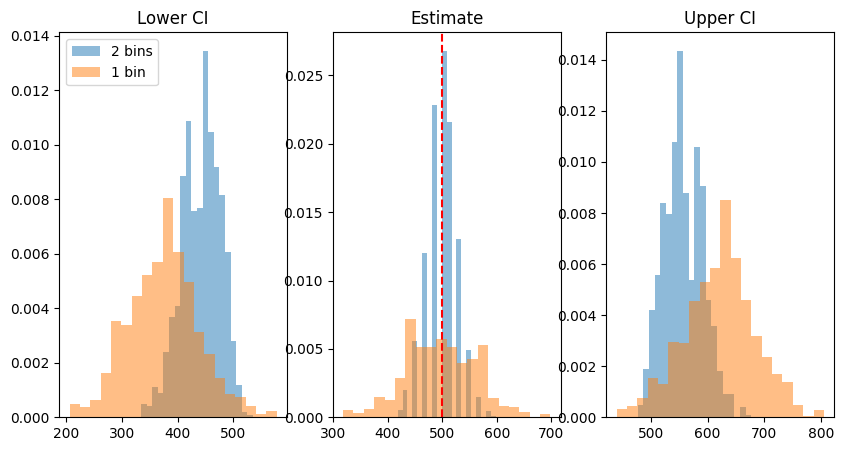

In [161]:
#
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# plot the lower CIs first
axs[0].hist(lowers, bins=20, alpha=0.5, label="2 bins", density=True)
axs[0].hist(single_lower, bins=20, alpha=0.5, label="1 bin", density=True)
# label
axs[0].legend()
# add title
axs[0].set_title("Lower CI")

# then means
axs[1].set_title("Estimate")
axs[1].hist(means, bins=20, alpha=0.5, label="2 bins", density=True)
axs[1].hist(single_mean, bins=20, alpha=0.5, label="1 bin", density=True)
# add a vertical line at true value
axs[1].axvline(bin1_size * p1 + bin2_size * p2, color='r', linestyle='--')
# then upper CIs
axs[2].set_title("Upper CI")
axs[2].hist(uppers, bins=20, alpha=0.5, label="2 bins", density=True)
axs[2].hist(single_upper, bins=20, alpha=0.5, label="1 bin", density=True)


(array([ 93.,   0.,   0.,   0.,   0.,   0., 249.,  45.,   0.,   0., 280.,
          7.,   1., 191.,   3.,  87.,   3.,  31.,   6.,   4.]),
 array([ 85.26514436, 101.32173383, 117.3783233 , 133.43491277,
        149.49150224, 165.54809171, 181.60468118, 197.66127065,
        213.71786012, 229.77444959, 245.83103906, 261.88762853,
        277.944218  , 294.00080747, 310.05739694, 326.11398641,
        342.17057588, 358.22716535, 374.28375482, 390.34034429,
        406.39693376]),
 <BarContainer object of 20 artists>)

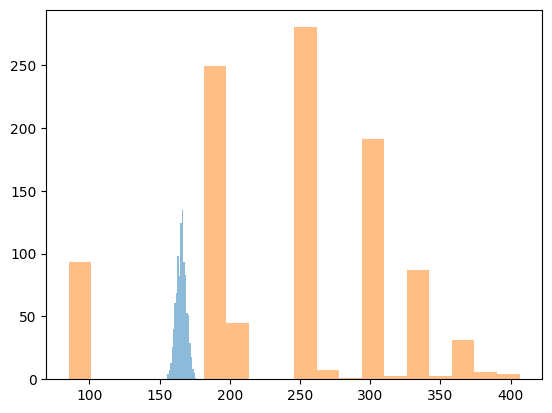

In [136]:
width = np.array(uppers) - np.array(lowers)
single_width = np.array(single_upper) - np.array(single_lower)
plt.hist(width, bins=20, alpha=0.5)
plt.hist(single_width, bins=20, alpha=0.5)

(array([ 93.,   0., 294.,   0., 287.,   0.,   0., 194.,   0.,   0.,  90.,
          0.,  32.,   0.,   0.,   6.,   0.,   3.,   0.,   1.]),
 array([ 14.5631068 ,  33.98058252,  53.39805825,  72.81553398,
         92.23300971, 111.65048544, 131.06796117, 150.48543689,
        169.90291262, 189.32038835, 208.73786408, 228.15533981,
        247.57281553, 266.99029126, 286.40776699, 305.82524272,
        325.24271845, 344.66019417, 364.0776699 , 383.49514563,
        402.91262136]),
 <BarContainer object of 20 artists>)

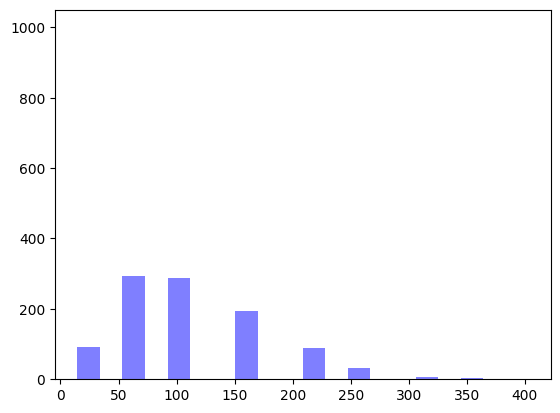

In [139]:
# plot the means
plt.hist(means, bins=20, alpha=0.5, color='r')
plt.hist(single_mean, bins=20, alpha=0.5, color='b')

(array([387., 287.,   0., 180.,  14.,   0.,  90.,   0.,   0.,  32.,   0.,
          0.,   5.,   1.,   0.,   0.,   3.,   0.,   0.,   1.]),
 array([9.38242548e-05, 1.03903397e+01, 2.07805856e+01, 3.11708314e+01,
        4.15610773e+01, 5.19513231e+01, 6.23415690e+01, 7.27318149e+01,
        8.31220607e+01, 9.35123066e+01, 1.03902552e+02, 1.14292798e+02,
        1.24683044e+02, 1.35073290e+02, 1.45463536e+02, 1.55853782e+02,
        1.66244028e+02, 1.76634274e+02, 1.87024519e+02, 1.97414765e+02,
        2.07805011e+02]),
 <BarContainer object of 20 artists>)

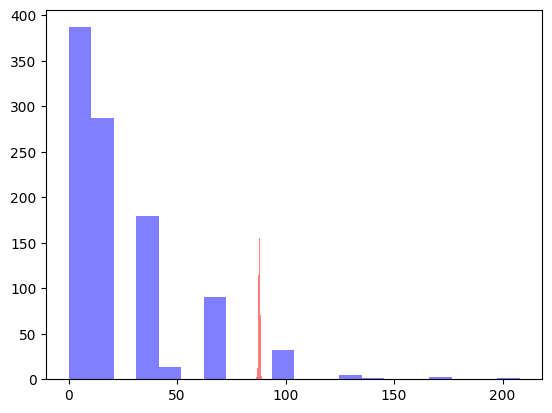

In [140]:
# plot the results
plt.hist(lowers, bins=20, alpha=0.5, color='r')
plt.hist(single_lower, bins=20, alpha=0.5, color='b')

(array([ 93.,   0.,   0.,   3., 291.,   0.,  16., 271.,   0., 194.,   0.,
         38.,  52.,   0.,  32.,   0.,   6.,   0.,   3.,   1.]),
 array([ 85.26530532, 111.71213729, 138.15896927, 164.60580125,
        191.05263323, 217.49946521, 243.94629718, 270.39312916,
        296.83996114, 323.28679312, 349.7336251 , 376.18045707,
        402.62728905, 429.07412103, 455.52095301, 481.96778499,
        508.41461696, 534.86144894, 561.30828092, 587.7551129 ,
        614.20194488]),
 <BarContainer object of 20 artists>)

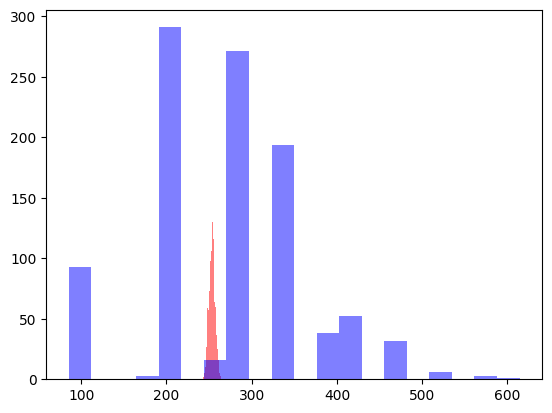

In [141]:
# plot the uppers
plt.hist(uppers, bins=20, alpha=0.5, color='r')
plt.hist(single_upper, bins=20, alpha=0.5, color='b')

In [129]:
print(posterior["lower_ci"], posterior["upper_ci"], posterior["estimate"])


88.40008246600961 247.8466664658262 122.64150943396224


In [102]:
posterior["estimate"]

np.float64(100.79840319361277)

In [81]:
dist

In [64]:
y2

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [65]:
bin1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,